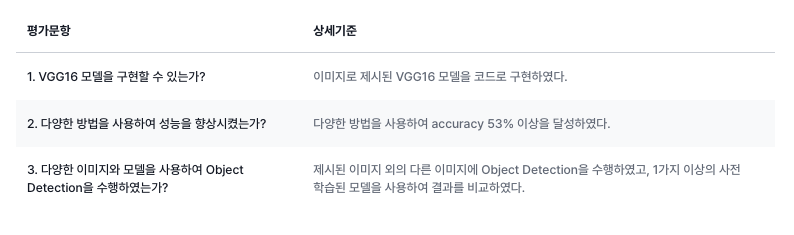

## Improve Accuracy 
우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미합니다.


https://www.kaggle.com/c/dogs-vs-cats/data
- 문제 1-1. VGG16 모델 구현하기  

영상의 내용을 참고하여 직접 코드로 모델을 구현해 보세요. Batch Normalization, Parameter Initialization 등을 사용할 수도 있습니다.

- 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기  

skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보세요.



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


* 필요한 파라미터를 설정해 줍시다. 파라미터를 수정하면 성능을 높일 수 있으니 다양한 실험을 해보세요.

In [19]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

* train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.

- Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

* .flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다. 우리는 개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'입니다. 
- Classification task에 따라 class_mode를 변경하시면 됩니다.

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


* Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [10]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

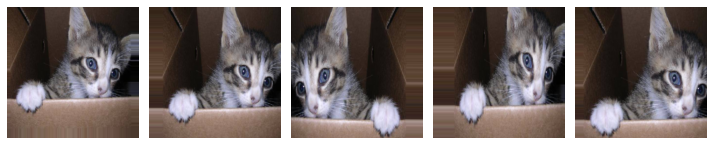

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

- Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [12]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [13]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


- Validation 데이터를 확인해 봅시다. 크게 이미지와 정답 데이터로 구성이 되어 있습니다.

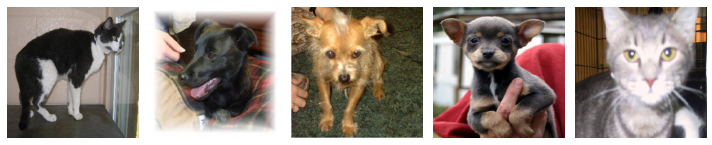

In [14]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [15]:
_[:5] # 정답 데이터

array([0., 1., 1., 1., 0.], dtype=float32)

# 문제 1-1. VGG16 모델 구현하기
- 이제 VGG16 모델을 구현해 볼 시간입니다. 바로 혼자서 모델을 구현하라고 하면 어렵겠죠? 그래서 참고할만한 모델 구현 코드를 아래에 적어 보았습니다. 실제 VGG16 모델과는 살짝 구조가 다르기 때문에 이미지를 보면서 어느 부분이 다른치 찾아 보는 것도 좋을 것 같습니다.



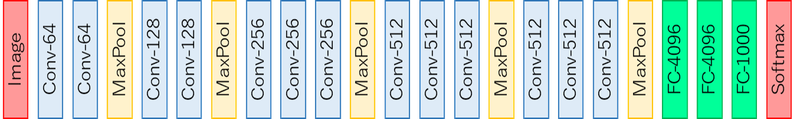

In [21]:
# 문제1-1. 이미지에 나온 VGG16 모델을 구현하세요.

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 128)       0   

- 손실함수, optimizer, metric을 설정해 줍니다. 손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있습니다. optimizer도 Adam 외에 다양한 것을 사용할 수 있습니다. 자유롭게 바꿔보세요.



In [23]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [24]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 42s 310ms/step - loss: 18070026.0000 - binary_accuracy: 0.5000 - val_loss: 0.7471 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 37s 295ms/step - loss: 0.7048 - binary_accuracy: 0.5000 - val_loss: 0.7155 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 38s 301ms/step - loss: 0.7085 - binary_accuracy: 0.5000 - val_loss: 0.7026 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 38s 299ms/step - loss: 0.6992 - binary_accuracy: 0.5000 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 38s 300ms/step - loss: 0.6965 - binary_accuracy: 0.5000 - val_loss: 0.7018 - val_binary_accuracy: 0.5000


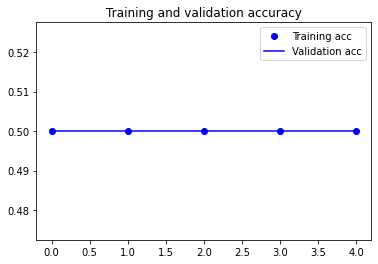

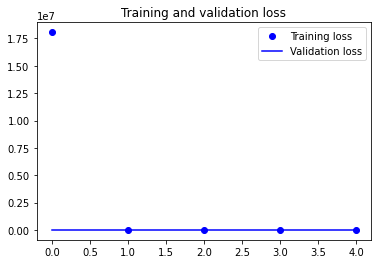

In [25]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
- hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 높일 수 있습니다. 다양한 실험을 통해 성능을 올려 보세요.

In [34]:
# 문제 1-2. hyperparameter 설정
# parameter Initialization
batch_size = 32
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [35]:
# 문제 1-2. 데이터 generator 생성
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.4,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.3,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
sample_training_images, _ = next(val_data_gen)
#plotImages(sample_training_images[:10])

augmented_images = [train_data_gen[0][0][0] for i in range(10)]
#plotImages(augmented_images)

In [41]:
# 문제 1-2. 모델 구현
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.1)


input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation=leaky_relu, padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation=leaky_relu, padding='same')(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation=leaky_relu)(x)
x=tf.keras.layers.Dense(4096, activation=leaky_relu)(x)
x=tf.keras.layers.Dense(1000, activation=leaky_relu)(x)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 128)       0   

In [42]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adagrad(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [43]:
# 모델 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/7
62/62 [==============================] - 55s 741ms/step - loss: 0.6933 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/7
62/62 [==============================] - 43s 687ms/step - loss: 0.6932 - binary_accuracy: 0.5000 - val_loss: 0.6930 - val_binary_accuracy: 0.5000
Epoch 3/7
62/62 [==============================] - 44s 695ms/step - loss: 0.6933 - binary_accuracy: 0.5000 - val_loss: 0.6929 - val_binary_accuracy: 0.5000
Epoch 4/7
62/62 [==============================] - 43s 690ms/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6928 - val_binary_accuracy: 0.5000
Epoch 5/7
62/62 [==============================] - 44s 696ms/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 6/7
62/62 [==============================] - 44s 691ms/step - loss: 0.6930 - binary_accuracy: 0.5000 - val_loss: 0.6929 - val_binary_accuracy: 0.5000
Epoch 7/7
62/62 [==============================] - 43s 688ms/ste

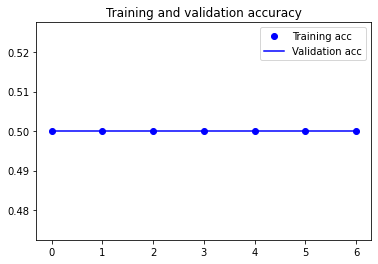

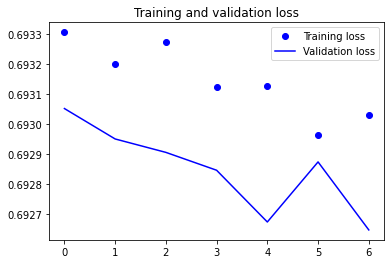

In [48]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# VGG16 모델 불러오기

In [53]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model

# 사전 학습된 모델 불러오기
input_tensor = Input(shape=(256,256,3))
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

In [54]:
# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output
# Cov2D Layer +
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)
# MaxPooling2D Layer +
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flatten Layer +
x = Flatten()(x)
# FC Layer +
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

# new model 정의
new_model = Model(inputs = model.input, outputs = x)

- loss function : sparse categorical crossentropy 사용
- optimizer : adam 사용

In [55]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in new_model.layers[:19] :
    layer.trainable = False

new_model.summary()

# 컴파일 옵션
new_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [ ]:
# 모델 학습
history = new_model.fit(
      train_data_gen,
      epochs=3,
      validation_data=val_data_gen,
      validation_freq=1)

new_model.save("newVGG16.h5")                        

Epoch 1/3
   1259/Unknown - 599s 476ms/step - loss: 0.1740 - accuracy: 0.9281

In [1]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



# 저장 모델 불러오기
from keras.models import load_model

new_model = load_model("newVGG16.h5")

NameError: name 'history' is not defined